In [5]:
# import torch

# # Check memory usage of all available GPUs
# for i in range(torch.cuda.device_count()):
#     print(f"GPU {i} - Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB, Reserved: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB, Free: {torch.cuda.memory_reserved(i) - torch.cuda.memory_allocated(i)} MB")

GPU 0 - Allocated: 0.00 MB, Reserved: 0.00 MB, Free: 0 MB
GPU 1 - Allocated: 0.00 MB, Reserved: 0.00 MB, Free: 0 MB
GPU 2 - Allocated: 0.00 MB, Reserved: 0.00 MB, Free: 0 MB
GPU 3 - Allocated: 0.00 MB, Reserved: 0.00 MB, Free: 0 MB
GPU 4 - Allocated: 0.00 MB, Reserved: 0.00 MB, Free: 0 MB
GPU 5 - Allocated: 0.00 MB, Reserved: 0.00 MB, Free: 0 MB
GPU 6 - Allocated: 0.00 MB, Reserved: 0.00 MB, Free: 0 MB
GPU 7 - Allocated: 0.00 MB, Reserved: 0.00 MB, Free: 0 MB


In [2]:
# import torch

# print("CUDA available:", torch.cuda.is_available())
# print("Number of GPUs:", torch.cuda.device_count())

CUDA available: True
Number of GPUs: 8


In [4]:
# torch.cuda.empty_cache()  # Releases all unused cached memory

In [3]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

device(type='cuda', index=0)

In [1]:
%load_ext nb_black

import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import datetime
from pprint import pprint
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader, Dataset

DATA = "/home/I6356345/project/data/triplets.tsv"
SEED = 566

/home/I6356345/anaconda3/envs/p37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>

In [2]:
# Fix random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<IPython.core.display.Javascript object>

## Read and tokenize dataset


In [3]:
def tokenize_columns(df, columns):
    # Create an empty vocabulary
    vocab = {}
    token_counter = 1  # Start token IDs from 1 (you can reserve 0 for padding if needed)

    # Function to add unique column values to the vocab
    def add_to_vocab(value):
        nonlocal token_counter
        if value not in vocab:
            vocab[value] = token_counter
            token_counter += 1

    # Add all unique values from the specified columns to the vocabulary
    for column in columns:
        df[column].apply(add_to_vocab)

    # Function to tokenize a column value based on the vocab
    def tokenize(value):
        return [vocab[value]]  # Return token ID as a list to keep compatibility with batch processing

    # Tokenize the specified columns
    for column in columns:
        df[f'tokenized_{column.lower().replace(" ", "_")}'] = df[column].apply(tokenize)

    # Combine tokenized concept and property into a single input sequence
    df['input_sequence'] = df.apply(lambda row: row['tokenized_concept'] + row['tokenized_property'], axis=1)

    return df, vocab


class TripletDataset(Dataset):
    def __init__(self, df):
        self.inputs = df['input_sequence'].tolist()
        self.targets = df['tokenized_related_concept'].tolist()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sequence = torch.tensor(self.inputs[idx], dtype=torch.long)
        target_sequence = torch.tensor(self.targets[idx], dtype=torch.long)
        return input_sequence, target_sequence


<IPython.core.display.Javascript object>

In [4]:
# Load TSV data
data = pd.read_csv(DATA, sep="\t")
df = data.sample(n=100000, random_state=SEED)
# df = data[:100000]
df.head()

,Concept,Property,Related Concept
1473772,ECG: U wave exaggerated,case_significance_id,900000000000017005
3289696,Talazoparib (as talazoparib tosylate) 1 mg ora...,definition_status_id,900000000000073002
471179,Pentostatin-containing product,definition_status_id,900000000000073002
670735,Fistulectomy of rectum,type_id,900000000000013009
693462,Excision of neurofibroma of cutaneous nerve,has_direct_procedure_site,Peripheral nerve structure


<IPython.core.display.Javascript object>

In [5]:
columns_to_tokenize = ["Concept", "Property", "Related Concept"]

df_tokenized, vocab = tokenize_columns(df, columns_to_tokenize)
display(df.head())
print("First 10 rows of Vocabulary:")
pprint(dict(list(vocab.items())[:10]))

,Concept,Property,Related Concept,tokenized_concept,tokenized_property,tokenized_related_concept,input_sequence
1473772,ECG: U wave exaggerated,case_significance_id,900000000000017005,[1],[88028],[88218],"[1, 88028]"
3289696,Talazoparib (as talazoparib tosylate) 1 mg ora...,definition_status_id,900000000000073002,[2],[88029],[88219],"[2, 88029]"
471179,Pentostatin-containing product,definition_status_id,900000000000073002,[3],[88029],[88219],"[3, 88029]"
670735,Fistulectomy of rectum,type_id,900000000000013009,[4],[88030],[88220],"[4, 88030]"
693462,Excision of neurofibroma of cutaneous nerve,has_direct_procedure_site,Peripheral nerve structure,[5],[88031],[88221],"[5, 88031]"


First 10 rows of Vocabulary:
{'Acute Q wave infarction - anterolateral': 6,
 'Blood group antibody P^k^': 8,
 'Cluster of differentiation antigen 45 R': 10,
 'ECG: U wave exaggerated': 1,
 'Excision of neurofibroma of cutaneous nerve': 5,
 'Fistulectomy of rectum': 4,
 'Ondansetron-containing product in parenteral dose form': 9,
 'Pentostatin-containing product': 3,
 'Stromeyer-Little operation hepatotomy': 7,
 'Talazoparib (as talazoparib tosylate) 1 mg oral capsule': 2}


<IPython.core.display.Javascript object>

## The Model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim


class GPTLikeModel(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, num_layers, max_seq_len, seed=42):
        super(GPTLikeModel, self).__init__()
        # Fix random seed for reproducibility
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_len, d_model))

        self.transformer_layers = nn.ModuleList(
            [
                nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads)
                for _ in range(num_layers)
            ]
        )

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # Embedding and positional encoding
        seq_len = x.size(1)
        x = self.embedding(x) + self.positional_encoding[:, :seq_len, :]

        # Pass through each transformer decoder layer
        for layer in self.transformer_layers:
            x = layer(x, x)  # Decoder takes input twice in GPT-like models

        # Output layer
        logits = self.fc_out(x)
        return logits

<IPython.core.display.Javascript object>

## Train and save

In [7]:
# model hyperparameters
vocab_size = len(vocab) + 1  # Include 1 for padding (if needed)
d_model = 128  # Embedding size
n_heads = 4  # Number of attention heads
num_layers = 1  # Number of transformer layers
max_seq_len = 2  # Maximum sequence length (concept + property)
batch_size = 64
lr = 0.001
# data params
n_values = [10, 100, 1000, 10000, 50000, 100000]
# n_values = [10, 100, 1000]
# epochs
epochs = 100


results = defaultdict(list)
final_models = {}
# Set the number of iterations for each n value
num_iterations = 10

for n in n_values:
    # Repeat the training process for each n value num_iterations times
    results_for_n = []  # Create a separate list for each n value
    for iteration in range(num_iterations):
        print(f"Training with n={n}, iteration={iteration + 1}")
        # Set a different seed for each iteration to get different accuracies
        iteration_seed = SEED + iteration
        
        # PREPARE EVTH
        # Create dataset and data loader
        dataset = TripletDataset(df.sample(n=n, random_state=iteration_seed))
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
        # Initialize the model
        model = GPTLikeModel(
            vocab_size, d_model, n_heads, num_layers, max_seq_len, seed=iteration_seed
        )
        
        torch.cuda.empty_cache()
        # Move the model to GPU if available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
    
        # Define the optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
    
        # RUN LAUNCHING
    
        # Training and testing loop (memorization task)
        model.train()
    
        for epoch in range(epochs):
            total_loss = 0
            model.train()  # Set model to training mode
    
            # Training on the same data
            for batch in tqdm(train_loader):
                inputs, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)
    
                # Forward pass
                optimizer.zero_grad()  # can be placed anywhere before loss.backward
                outputs = model(inputs)
    
                # We only care about the first token in the output sequence
                outputs = outputs[:, 0, :]  # Shape becomes: (batch_size, vocab_size)
    
                targets = targets.view(-1)  # Flatten the targets
    
                # Compute loss
                loss = criterion(outputs, targets)
    
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
    
                total_loss += loss.item()
    
            print(f"Epoch {epoch + 1}, Training Loss: {total_loss / len(train_loader)}")
            if epoch % 2 != 0:
                continue
            # Testing on the same data (memorization check)
            model.eval()  # Set model to evaluation mode
            correct = 0
            total = 0
            with torch.no_grad():
                for batch in tqdm(train_loader):  # Testing on the same dataset
                    inputs, targets = batch
                    inputs = inputs.to(device)
                    targets = targets.to(device)
    
                    outputs = model(inputs)
                    outputs = outputs[:, 0, :]  # Only take the first token prediction
                    predicted = torch.argmax(outputs, dim=1)
    
                    total += targets.size(0)
                    correct += (predicted == targets.view(-1)).sum().item()
            #             print(total, correct)
    
            accuracy = 100 * correct / total
            print(f"Epoch {epoch + 1}, Memorization Accuracy: {accuracy:.5f}%")
            results_for_n.append(accuracy)
        # Save the final model for this iteration
        final_models[(n, iteration)] = model
    
    # Save all accuracies for the current n value
    results[n].append(results_for_n)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch 1, Training Loss: 11.601882934570312


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 339.07it/s]


Epoch 1, Memorization Accuracy: 10.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.02it/s]


Epoch 2, Training Loss: 10.005620956420898


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.83it/s]


Epoch 3, Training Loss: 8.685819625854492


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 415.57it/s]


Epoch 3, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 103.51it/s]


Epoch 4, Training Loss: 7.799527168273926


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.99it/s]


Epoch 5, Training Loss: 7.081579685211182


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 444.78it/s]


Epoch 5, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.38it/s]


Epoch 6, Training Loss: 6.5146918296813965


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.12it/s]


Epoch 7, Training Loss: 6.029248237609863


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 461.93it/s]


Epoch 7, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 95.19it/s]


Epoch 8, Training Loss: 5.628953456878662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 90.39it/s]


Epoch 9, Training Loss: 5.238653659820557


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 329.35it/s]


Epoch 9, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 84.12it/s]


Epoch 10, Training Loss: 5.021542072296143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 97.31it/s]


Epoch 11, Training Loss: 4.743313789367676


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 483.44it/s]


Epoch 11, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.45it/s]


Epoch 12, Training Loss: 4.545643329620361


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.19it/s]


Epoch 13, Training Loss: 4.448855876922607


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 428.51it/s]


Epoch 13, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 103.04it/s]


Epoch 14, Training Loss: 4.284334659576416


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 101.01it/s]


Epoch 15, Training Loss: 4.091675281524658


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 504.49it/s]


Epoch 15, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.55it/s]


Epoch 16, Training Loss: 3.951984405517578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.45it/s]


Epoch 17, Training Loss: 3.7834105491638184


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 508.83it/s]


Epoch 17, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 103.72it/s]


Epoch 18, Training Loss: 3.5782413482666016


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.58it/s]


Epoch 19, Training Loss: 3.4218742847442627


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 424.05it/s]


Epoch 19, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.16it/s]


Epoch 20, Training Loss: 3.2696216106414795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 97.88it/s]


Epoch 21, Training Loss: 3.1167290210723877


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 401.64it/s]


Epoch 21, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 96.43it/s]


Epoch 22, Training Loss: 2.9184067249298096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 97.77it/s]


Epoch 23, Training Loss: 2.7611849308013916


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 400.68it/s]


Epoch 23, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 97.97it/s]


Epoch 24, Training Loss: 2.581740140914917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.46it/s]


Epoch 25, Training Loss: 2.376028060913086


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 390.17it/s]


Epoch 25, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 93.86it/s]


Epoch 26, Training Loss: 2.2263786792755127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 86.19it/s]


Epoch 27, Training Loss: 2.0417466163635254


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 503.94it/s]


Epoch 27, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.54it/s]


Epoch 28, Training Loss: 1.8778817653656006


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.18it/s]


Epoch 29, Training Loss: 1.708665132522583


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 445.44it/s]


Epoch 29, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.24it/s]


Epoch 30, Training Loss: 1.5583040714263916


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 104.77it/s]


Epoch 31, Training Loss: 1.4059879779815674


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 510.26it/s]


Epoch 31, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.29it/s]


Epoch 32, Training Loss: 1.2897684574127197


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 105.98it/s]


Epoch 33, Training Loss: 1.1239184141159058


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 451.15it/s]


Epoch 33, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.36it/s]


Epoch 34, Training Loss: 0.9915132522583008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 95.25it/s]


Epoch 35, Training Loss: 0.9136372804641724


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 285.37it/s]


Epoch 35, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 93.12it/s]


Epoch 36, Training Loss: 0.8022173643112183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 89.47it/s]


Epoch 37, Training Loss: 0.7007646560668945


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 381.99it/s]


Epoch 37, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 91.32it/s]


Epoch 38, Training Loss: 0.6144171953201294


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.97it/s]


Epoch 39, Training Loss: 0.5275508165359497


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 543.23it/s]


Epoch 39, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 103.08it/s]


Epoch 40, Training Loss: 0.471935510635376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 83.80it/s]


Epoch 41, Training Loss: 0.4109105169773102


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 324.79it/s]


Epoch 41, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 93.55it/s]


Epoch 42, Training Loss: 0.37734121084213257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 92.45it/s]


Epoch 43, Training Loss: 0.34593069553375244


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 423.45it/s]


Epoch 43, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 93.11it/s]


Epoch 44, Training Loss: 0.25294598937034607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 93.89it/s]


Epoch 45, Training Loss: 0.22765043377876282


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 427.86it/s]


Epoch 45, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 97.83it/s]


Epoch 46, Training Loss: 0.20748014748096466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 94.24it/s]


Epoch 47, Training Loss: 0.17825067043304443


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 349.73it/s]


Epoch 47, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.74it/s]


Epoch 48, Training Loss: 0.1808963567018509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 67.64it/s]


Epoch 49, Training Loss: 0.1345682442188263


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 306.71it/s]


Epoch 49, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.14it/s]


Epoch 50, Training Loss: 0.14537103474140167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.13it/s]


Epoch 51, Training Loss: 0.12027662992477417


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 442.30it/s]


Epoch 51, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 101.95it/s]


Epoch 52, Training Loss: 0.10412731021642685


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.39it/s]


Epoch 53, Training Loss: 0.10915659368038177


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 437.82it/s]


Epoch 53, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 105.58it/s]


Epoch 54, Training Loss: 0.0773211196064949


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 101.56it/s]


Epoch 55, Training Loss: 0.0776316374540329


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 444.03it/s]


Epoch 55, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 101.43it/s]


Epoch 56, Training Loss: 0.07895876467227936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 97.76it/s]


Epoch 57, Training Loss: 0.07308504730463028


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 432.67it/s]


Epoch 57, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.95it/s]


Epoch 58, Training Loss: 0.06244450807571411


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.71it/s]


Epoch 59, Training Loss: 0.06094808131456375


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 520.51it/s]


Epoch 59, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 101.14it/s]


Epoch 60, Training Loss: 0.05211078003048897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 76.60it/s]


Epoch 61, Training Loss: 0.053736377507448196


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 409.00it/s]


Epoch 61, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 93.22it/s]


Epoch 62, Training Loss: 0.05124345421791077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 86.16it/s]


Epoch 63, Training Loss: 0.05174440145492554


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 395.61it/s]


Epoch 63, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.53it/s]


Epoch 64, Training Loss: 0.04914451017975807


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 101.06it/s]


Epoch 65, Training Loss: 0.038428597152233124


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 518.65it/s]


Epoch 65, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 105.18it/s]


Epoch 66, Training Loss: 0.044837623834609985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.76it/s]


Epoch 67, Training Loss: 0.03744742274284363


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 520.32it/s]


Epoch 67, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.98it/s]


Epoch 68, Training Loss: 0.04084156081080437


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 104.68it/s]


Epoch 69, Training Loss: 0.035341233015060425


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 447.44it/s]


Epoch 69, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.59it/s]


Epoch 70, Training Loss: 0.038212940096855164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.10it/s]


Epoch 71, Training Loss: 0.034167226403951645


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 418.18it/s]


Epoch 71, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 97.35it/s]


Epoch 72, Training Loss: 0.031378526240587234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 95.47it/s]


Epoch 73, Training Loss: 0.030479129403829575


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 367.73it/s]


Epoch 73, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 94.42it/s]


Epoch 74, Training Loss: 0.03076997958123684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.38it/s]


Epoch 75, Training Loss: 0.02872069738805294


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 414.33it/s]


Epoch 75, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.00it/s]


Epoch 76, Training Loss: 0.028397034853696823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 86.31it/s]


Epoch 77, Training Loss: 0.02867805026471615


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 521.94it/s]


Epoch 77, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.37it/s]


Epoch 78, Training Loss: 0.02629454806447029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.64it/s]


Epoch 79, Training Loss: 0.026634305715560913


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 526.79it/s]


Epoch 79, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.56it/s]


Epoch 80, Training Loss: 0.024741586297750473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.64it/s]


Epoch 81, Training Loss: 0.02698601223528385


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 524.55it/s]


Epoch 81, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.04it/s]


Epoch 82, Training Loss: 0.02639750763773918


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 103.14it/s]


Epoch 83, Training Loss: 0.02493574470281601


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 453.68it/s]


Epoch 83, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 106.03it/s]


Epoch 84, Training Loss: 0.024928562343120575


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.78it/s]


Epoch 85, Training Loss: 0.023312697187066078


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 527.59it/s]


Epoch 85, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 103.19it/s]


Epoch 86, Training Loss: 0.023441098630428314


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.11it/s]


Epoch 87, Training Loss: 0.02180997096002102


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 518.97it/s]


Epoch 87, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 101.47it/s]


Epoch 88, Training Loss: 0.02335277944803238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 88.74it/s]


Epoch 89, Training Loss: 0.022977003827691078


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 442.90it/s]


Epoch 89, Memorization Accuracy: 100.00000%


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 101.57it/s]


Epoch 90, Training Loss: 0.02203255519270897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 80.90it/s]


Epoch 91, Training Loss: 0.02129325456917286


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 402.49it/s]


Epoch 91, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 96.19it/s]


Epoch 92, Training Loss: 0.020926687866449356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 95.11it/s]


Epoch 93, Training Loss: 0.020718976855278015


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 410.04it/s]


Epoch 93, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 94.17it/s]


Epoch 94, Training Loss: 0.01982063800096512


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.09it/s]


Epoch 95, Training Loss: 0.017908837646245956


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 533.63it/s]


Epoch 95, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 99.07it/s]


Epoch 96, Training Loss: 0.020875198766589165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.16it/s]


Epoch 97, Training Loss: 0.020610064268112183


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 429.00it/s]


Epoch 97, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 95.30it/s]


Epoch 98, Training Loss: 0.017987340688705444


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 100.33it/s]


Epoch 99, Training Loss: 0.019105326384305954


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 552.97it/s]


Epoch 99, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 98.92it/s]


Epoch 100, Training Loss: 0.019939351826906204


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 79.91it/s]


Epoch 1, Training Loss: 11.679989337921143


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 382.20it/s]


Epoch 1, Memorization Accuracy: 0.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 82.80it/s]


Epoch 2, Training Loss: 10.647495746612549


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.08it/s]


Epoch 3, Training Loss: 9.899580955505371


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 390.57it/s]


Epoch 3, Memorization Accuracy: 27.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.10it/s]


Epoch 4, Training Loss: 9.312352657318115


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 90.24it/s]


Epoch 5, Training Loss: 8.757383346557617


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 339.73it/s]


Epoch 5, Memorization Accuracy: 46.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 92.43it/s]


Epoch 6, Training Loss: 8.23813247680664


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 95.93it/s]


Epoch 7, Training Loss: 7.60794997215271


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 380.73it/s]


Epoch 7, Memorization Accuracy: 71.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 69.83it/s]


Epoch 8, Training Loss: 6.98669695854187


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 92.20it/s]


Epoch 9, Training Loss: 6.392502069473267


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 389.37it/s]


Epoch 9, Memorization Accuracy: 92.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 91.03it/s]


Epoch 10, Training Loss: 5.824278831481934


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.86it/s]


Epoch 11, Training Loss: 5.414279222488403


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 387.02it/s]


Epoch 11, Memorization Accuracy: 98.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 90.69it/s]


Epoch 12, Training Loss: 4.901912450790405


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 85.65it/s]


Epoch 13, Training Loss: 4.410348415374756


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 387.73it/s]


Epoch 13, Memorization Accuracy: 99.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.92it/s]


Epoch 14, Training Loss: 3.937894105911255


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 92.90it/s]


Epoch 15, Training Loss: 3.48291015625


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 390.46it/s]


Epoch 15, Memorization Accuracy: 96.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 96.49it/s]


Epoch 16, Training Loss: 3.1373003721237183


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 89.86it/s]


Epoch 17, Training Loss: 2.6924017667770386


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 404.31it/s]


Epoch 17, Memorization Accuracy: 98.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 98.45it/s]


Epoch 18, Training Loss: 2.386862635612488


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 58.75it/s]


Epoch 19, Training Loss: 2.0412631034851074


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 360.43it/s]


Epoch 19, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 90.27it/s]


Epoch 20, Training Loss: 1.753147840499878


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 95.29it/s]


Epoch 21, Training Loss: 1.503484070301056


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 376.42it/s]


Epoch 21, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.97it/s]


Epoch 22, Training Loss: 1.229121744632721


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.37it/s]


Epoch 23, Training Loss: 1.0413849353790283


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 370.75it/s]


Epoch 23, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 92.61it/s]


Epoch 24, Training Loss: 0.8264844417572021


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.81it/s]


Epoch 25, Training Loss: 0.698433518409729


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 393.87it/s]


Epoch 25, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.16it/s]


Epoch 26, Training Loss: 0.5797755420207977


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.47it/s]


Epoch 27, Training Loss: 0.4993819296360016


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 289.75it/s]


Epoch 27, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 90.86it/s]


Epoch 28, Training Loss: 0.40215256810188293


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.49it/s]


Epoch 29, Training Loss: 0.3463701158761978


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 348.57it/s]


Epoch 29, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 96.13it/s]


Epoch 30, Training Loss: 0.29586245119571686


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.14it/s]


Epoch 31, Training Loss: 0.24609579145908356


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 368.76it/s]


Epoch 31, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 88.09it/s]


Epoch 32, Training Loss: 0.23161102086305618


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.59it/s]


Epoch 33, Training Loss: 0.2009151354432106


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 364.77it/s]


Epoch 33, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 92.99it/s]


Epoch 34, Training Loss: 0.19396859407424927


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.61it/s]


Epoch 35, Training Loss: 0.16085945814847946


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 378.36it/s]


Epoch 35, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.34it/s]


Epoch 36, Training Loss: 0.14709524810314178


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 90.28it/s]


Epoch 37, Training Loss: 0.12850352376699448


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 374.78it/s]


Epoch 37, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.94it/s]


Epoch 38, Training Loss: 0.11130760610103607


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 66.64it/s]


Epoch 39, Training Loss: 0.104677964001894


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 351.56it/s]


Epoch 39, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 84.19it/s]


Epoch 40, Training Loss: 0.10369961336255074


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.01it/s]


Epoch 41, Training Loss: 0.09584211930632591


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 386.50it/s]


Epoch 41, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.57it/s]


Epoch 42, Training Loss: 0.08741379156708717


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.79it/s]


Epoch 43, Training Loss: 0.08680009096860886


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 394.44it/s]


Epoch 43, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.15it/s]


Epoch 44, Training Loss: 0.0794619731605053


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 91.08it/s]


Epoch 45, Training Loss: 0.07790134847164154


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 364.77it/s]


Epoch 45, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 90.32it/s]


Epoch 46, Training Loss: 0.07631432265043259


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 82.16it/s]


Epoch 47, Training Loss: 0.06918934732675552


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 356.49it/s]

Epoch 47, Memorization Accuracy: 100.00000%



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 86.53it/s]


Epoch 48, Training Loss: 0.06686092168092728


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 80.22it/s]


Epoch 49, Training Loss: 0.06449488922953606


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 356.36it/s]


Epoch 49, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 89.67it/s]


Epoch 50, Training Loss: 0.06446845456957817


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 92.68it/s]


Epoch 51, Training Loss: 0.06046026013791561


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 364.48it/s]


Epoch 51, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 90.61it/s]


Epoch 52, Training Loss: 0.056896209716796875


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 91.59it/s]


Epoch 53, Training Loss: 0.056325824931263924


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 344.94it/s]


Epoch 53, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 90.77it/s]


Epoch 54, Training Loss: 0.05317697674036026


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 91.70it/s]


Epoch 55, Training Loss: 0.05003290809690952


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 377.95it/s]


Epoch 55, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 92.55it/s]


Epoch 56, Training Loss: 0.04981984756886959


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.12it/s]


Epoch 57, Training Loss: 0.049817075952887535


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 368.47it/s]


Epoch 57, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.89it/s]


Epoch 58, Training Loss: 0.0482906848192215


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 61.21it/s]


Epoch 59, Training Loss: 0.046086136251688004


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 327.71it/s]


Epoch 59, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 90.08it/s]


Epoch 60, Training Loss: 0.04525540769100189


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 91.67it/s]


Epoch 61, Training Loss: 0.043915098533034325


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 367.45it/s]


Epoch 61, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.00it/s]


Epoch 62, Training Loss: 0.04335991106927395


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 92.26it/s]


Epoch 63, Training Loss: 0.0400361530482769


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 386.38it/s]


Epoch 63, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.07it/s]


Epoch 64, Training Loss: 0.04373146966099739


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 76.34it/s]


Epoch 65, Training Loss: 0.04183829762041569


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 269.42it/s]


Epoch 65, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 79.22it/s]


Epoch 66, Training Loss: 0.03882204554975033


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 81.36it/s]


Epoch 67, Training Loss: 0.03877846896648407


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 366.06it/s]


Epoch 67, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 83.50it/s]


Epoch 68, Training Loss: 0.03667502477765083


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 84.83it/s]


Epoch 69, Training Loss: 0.035080451518297195


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 370.55it/s]


Epoch 69, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 92.73it/s]


Epoch 70, Training Loss: 0.03615388087928295


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 92.15it/s]


Epoch 71, Training Loss: 0.03429156914353371


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 387.36it/s]


Epoch 71, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.62it/s]


Epoch 72, Training Loss: 0.03544848971068859


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 87.04it/s]


Epoch 73, Training Loss: 0.033108185045421124


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 280.92it/s]


Epoch 73, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 80.22it/s]


Epoch 74, Training Loss: 0.03180017601698637


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 87.29it/s]


Epoch 75, Training Loss: 0.03292228281497955


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 370.72it/s]


Epoch 75, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 87.97it/s]


Epoch 76, Training Loss: 0.032361309975385666


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.23it/s]


Epoch 77, Training Loss: 0.028862987644970417


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 423.22it/s]


Epoch 77, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 63.35it/s]


Epoch 78, Training Loss: 0.029605000279843807


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 82.78it/s]


Epoch 79, Training Loss: 0.030972393229603767


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 378.67it/s]


Epoch 79, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 92.55it/s]


Epoch 80, Training Loss: 0.02894887700676918


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.92it/s]


Epoch 81, Training Loss: 0.029874001629650593


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 367.91it/s]


Epoch 81, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.31it/s]


Epoch 82, Training Loss: 0.027811186388134956


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 91.59it/s]


Epoch 83, Training Loss: 0.029197300784289837


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 316.41it/s]


Epoch 83, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 91.47it/s]


Epoch 84, Training Loss: 0.027073832228779793


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 87.65it/s]


Epoch 85, Training Loss: 0.028118141926825047


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 358.90it/s]


Epoch 85, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 84.30it/s]


Epoch 86, Training Loss: 0.02654949389398098


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 82.54it/s]


Epoch 87, Training Loss: 0.02502689976245165


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 360.20it/s]


Epoch 87, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 81.46it/s]


Epoch 88, Training Loss: 0.025258696638047695


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 82.42it/s]


Epoch 89, Training Loss: 0.023006747476756573


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 317.67it/s]


Epoch 89, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 88.16it/s]


Epoch 90, Training Loss: 0.024928643368184566


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 87.72it/s]


Epoch 91, Training Loss: 0.024538314901292324


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 309.19it/s]


Epoch 91, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 87.62it/s]


Epoch 92, Training Loss: 0.024836121127009392


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 87.67it/s]


Epoch 93, Training Loss: 0.023297125473618507


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 309.70it/s]


Epoch 93, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 86.31it/s]


Epoch 94, Training Loss: 0.022957407869398594


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 87.16it/s]


Epoch 95, Training Loss: 0.023373101837933064


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 321.99it/s]


Epoch 95, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 90.87it/s]


Epoch 96, Training Loss: 0.022493031807243824


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 92.99it/s]


Epoch 97, Training Loss: 0.0225865188986063


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 368.47it/s]


Epoch 97, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 94.95it/s]


Epoch 98, Training Loss: 0.02128870226442814


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 93.67it/s]


Epoch 99, Training Loss: 0.02152843400835991


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 319.81it/s]


Epoch 99, Memorization Accuracy: 100.00000%


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 84.29it/s]


Epoch 100, Training Loss: 0.021232138387858868


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 87.72it/s]


Epoch 1, Training Loss: 10.677713394165039


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 269.53it/s]


Epoch 1, Memorization Accuracy: 12.50000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.05it/s]


Epoch 2, Training Loss: 7.747635722160339


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 87.73it/s]


Epoch 3, Training Loss: 5.630563974380493


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 350.71it/s]


Epoch 3, Memorization Accuracy: 16.70000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.89it/s]


Epoch 4, Training Loss: 4.979104459285736


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.47it/s]


Epoch 5, Training Loss: 4.568628966808319


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 345.85it/s]


Epoch 5, Memorization Accuracy: 29.30000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 86.71it/s]


Epoch 6, Training Loss: 3.967146098613739


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.19it/s]


Epoch 7, Training Loss: 3.316514864563942


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 370.48it/s]


Epoch 7, Memorization Accuracy: 43.80000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 83.63it/s]


Epoch 8, Training Loss: 2.587570309638977


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 84.29it/s]


Epoch 9, Training Loss: 1.9247184991836548


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 340.57it/s]


Epoch 9, Memorization Accuracy: 80.60000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 93.59it/s]


Epoch 10, Training Loss: 1.3529695719480515


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 96.70it/s]


Epoch 11, Training Loss: 0.9191733710467815


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 429.02it/s]


Epoch 11, Memorization Accuracy: 99.90000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 97.57it/s]


Epoch 12, Training Loss: 0.5986826084554195


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 96.98it/s]


Epoch 13, Training Loss: 0.3941937666386366


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 437.63it/s]


Epoch 13, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 97.12it/s]


Epoch 14, Training Loss: 0.2579348059371114


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 84.44it/s]


Epoch 15, Training Loss: 0.17839735886082053


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 401.83it/s]


Epoch 15, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.62it/s]


Epoch 16, Training Loss: 0.1412646258249879


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 81.38it/s]


Epoch 17, Training Loss: 0.10915647074580193


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 378.81it/s]


Epoch 17, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.16it/s]


Epoch 18, Training Loss: 0.08979126997292042


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 79.95it/s]


Epoch 19, Training Loss: 0.07700015162117779


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 380.53it/s]


Epoch 19, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 86.73it/s]


Epoch 20, Training Loss: 0.06700352393090725


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 84.17it/s]


Epoch 21, Training Loss: 0.05884162522852421


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 373.70it/s]


Epoch 21, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.61it/s]


Epoch 22, Training Loss: 0.05131939519196749


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 87.04it/s]


Epoch 23, Training Loss: 0.046921426663175225


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 353.81it/s]


Epoch 23, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 90.30it/s]


Epoch 24, Training Loss: 0.041865671053528786


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 82.12it/s]


Epoch 25, Training Loss: 0.03876897436566651


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 372.67it/s]


Epoch 25, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 77.49it/s]


Epoch 26, Training Loss: 0.03473281080368906


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 83.39it/s]


Epoch 27, Training Loss: 0.03245745797175914


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 378.69it/s]


Epoch 27, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 90.04it/s]


Epoch 28, Training Loss: 0.029391070478595793


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.23it/s]


Epoch 29, Training Loss: 0.02745652780868113


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 405.32it/s]


Epoch 29, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 84.22it/s]


Epoch 30, Training Loss: 0.025474404450505972


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 92.36it/s]


Epoch 31, Training Loss: 0.024430663674138486


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 380.52it/s]


Epoch 31, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 91.53it/s]


Epoch 32, Training Loss: 0.022444589878432453


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 80.94it/s]


Epoch 33, Training Loss: 0.020821227808482945


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 327.76it/s]


Epoch 33, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 91.20it/s]


Epoch 34, Training Loss: 0.019351430237293243


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 87.91it/s]


Epoch 35, Training Loss: 0.018682760768570006


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 354.46it/s]


Epoch 35, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 91.52it/s]


Epoch 36, Training Loss: 0.0178042120533064


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.90it/s]


Epoch 37, Training Loss: 0.016984031244646758


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 367.66it/s]


Epoch 37, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 86.58it/s]


Epoch 38, Training Loss: 0.01621059194440022


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.07it/s]


Epoch 39, Training Loss: 0.015006133529823273


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 381.95it/s]


Epoch 39, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 87.22it/s]


Epoch 40, Training Loss: 0.014576245448552072


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.97it/s]


Epoch 41, Training Loss: 0.014044017938431352


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 364.08it/s]


Epoch 41, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.68it/s]


Epoch 42, Training Loss: 0.013231256045401096


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 92.39it/s]


Epoch 43, Training Loss: 0.01264330989215523


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 358.43it/s]


Epoch 43, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.69it/s]


Epoch 44, Training Loss: 0.01186995895113796


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.65it/s]


Epoch 45, Training Loss: 0.01148602063767612


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 367.77it/s]


Epoch 45, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 91.02it/s]


Epoch 46, Training Loss: 0.011221291671972722


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.76it/s]


Epoch 47, Training Loss: 0.010954461642540991


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 328.45it/s]


Epoch 47, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 85.42it/s]


Epoch 48, Training Loss: 0.010367418173700571


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 84.37it/s]


Epoch 49, Training Loss: 0.01005121084745042


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 364.68it/s]


Epoch 49, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 86.92it/s]


Epoch 50, Training Loss: 0.009727884375024587


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.33it/s]


Epoch 51, Training Loss: 0.009079210605705157


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 383.94it/s]


Epoch 51, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 81.69it/s]


Epoch 52, Training Loss: 0.00897510803770274


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.65it/s]


Epoch 53, Training Loss: 0.008502878015860915


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 389.80it/s]


Epoch 53, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 87.94it/s]


Epoch 54, Training Loss: 0.008294817118439823


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 83.00it/s]


Epoch 55, Training Loss: 0.0078555611835327


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 370.45it/s]


Epoch 55, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 87.12it/s]


Epoch 56, Training Loss: 0.007727633434114978


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.66it/s]


Epoch 57, Training Loss: 0.007698120141867548


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 406.43it/s]


Epoch 57, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 96.55it/s]


Epoch 58, Training Loss: 0.007365954777924344


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 95.94it/s]


Epoch 59, Training Loss: 0.007005831808783114


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 420.43it/s]


Epoch 59, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 97.20it/s]


Epoch 60, Training Loss: 0.006840765825472772


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 96.91it/s]


Epoch 61, Training Loss: 0.006529952108394355


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 430.25it/s]


Epoch 61, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 97.57it/s]


Epoch 62, Training Loss: 0.006426137581001967


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.28it/s]


Epoch 63, Training Loss: 0.006365019944496453


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 334.73it/s]


Epoch 63, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 77.00it/s]


Epoch 64, Training Loss: 0.005913704866543412


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 82.05it/s]


Epoch 65, Training Loss: 0.005793266871478409


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 272.05it/s]


Epoch 65, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 86.35it/s]


Epoch 66, Training Loss: 0.0056905960373114794


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 90.59it/s]


Epoch 67, Training Loss: 0.005739911372074857


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 324.94it/s]


Epoch 67, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 91.07it/s]


Epoch 68, Training Loss: 0.0052697360661113635


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.49it/s]


Epoch 69, Training Loss: 0.005280748096993193


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 399.31it/s]


Epoch 69, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.39it/s]


Epoch 70, Training Loss: 0.005178773571969941


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 91.59it/s]


Epoch 71, Training Loss: 0.005106688913656399


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 349.37it/s]


Epoch 71, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.52it/s]


Epoch 72, Training Loss: 0.004734789486974478


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 90.89it/s]


Epoch 73, Training Loss: 0.0047472999431192875


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 386.76it/s]


Epoch 73, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.25it/s]


Epoch 74, Training Loss: 0.004679618738009594


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.43it/s]


Epoch 75, Training Loss: 0.0045368246210273355


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 362.16it/s]


Epoch 75, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 85.99it/s]


Epoch 76, Training Loss: 0.004258928864146583


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 84.40it/s]


Epoch 77, Training Loss: 0.004355473924078979


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 383.26it/s]


Epoch 77, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 90.73it/s]


Epoch 78, Training Loss: 0.004270009711035527


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 92.08it/s]


Epoch 79, Training Loss: 0.004074185388162732


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 394.49it/s]


Epoch 79, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 84.78it/s]


Epoch 80, Training Loss: 0.003983629576396197


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 93.69it/s]


Epoch 81, Training Loss: 0.003924939301214181


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 410.35it/s]


Epoch 81, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 91.98it/s]


Epoch 82, Training Loss: 0.0037072121776873246


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 87.24it/s]


Epoch 83, Training Loss: 0.003759203595109284


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 396.47it/s]


Epoch 83, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.73it/s]


Epoch 84, Training Loss: 0.003766900845221244


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 86.15it/s]


Epoch 85, Training Loss: 0.00349478458520025


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 357.01it/s]


Epoch 85, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.73it/s]


Epoch 86, Training Loss: 0.003515157397487201


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 85.25it/s]


Epoch 87, Training Loss: 0.003463708417257294


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 384.02it/s]


Epoch 87, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 85.96it/s]


Epoch 88, Training Loss: 0.0033669847762212157


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 93.22it/s]


Epoch 89, Training Loss: 0.0032336341828340665


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 378.47it/s]


Epoch 89, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 87.19it/s]


Epoch 90, Training Loss: 0.0031278855458367616


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 86.26it/s]


Epoch 91, Training Loss: 0.0032030930160544813


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 398.15it/s]


Epoch 91, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 93.33it/s]


Epoch 92, Training Loss: 0.00314036788768135


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 91.46it/s]


Epoch 93, Training Loss: 0.002909010407165624


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 380.01it/s]


Epoch 93, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.05it/s]


Epoch 94, Training Loss: 0.0028983469237573445


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.98it/s]


Epoch 95, Training Loss: 0.0029512134060496464


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 381.67it/s]


Epoch 95, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 91.77it/s]


Epoch 96, Training Loss: 0.002907122572651133


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 88.10it/s]


Epoch 97, Training Loss: 0.00286007922841236


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 403.62it/s]


Epoch 97, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.54it/s]


Epoch 98, Training Loss: 0.0027249599079368636


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 90.22it/s]


Epoch 99, Training Loss: 0.002643688967509661


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 249.07it/s]


Epoch 99, Memorization Accuracy: 100.00000%


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 89.61it/s]


Epoch 100, Training Loss: 0.0026072332984767854


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 91.49it/s]


Epoch 1, Training Loss: 8.090755581096479


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 384.92it/s]


Epoch 1, Memorization Accuracy: 12.00000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.93it/s]


Epoch 2, Training Loss: 6.2360259560263085


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.81it/s]


Epoch 3, Training Loss: 5.701727256653415


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 353.28it/s]


Epoch 3, Memorization Accuracy: 22.44000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.96it/s]


Epoch 4, Training Loss: 4.680840741297242


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.54it/s]


Epoch 5, Training Loss: 3.2605017309735533


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 377.80it/s]


Epoch 5, Memorization Accuracy: 72.43000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 91.98it/s]


Epoch 6, Training Loss: 1.7160318345780585


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.41it/s]


Epoch 7, Training Loss: 0.6234031522729594


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 373.59it/s]


Epoch 7, Memorization Accuracy: 98.28000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.07it/s]


Epoch 8, Training Loss: 0.26358763797647633


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.38it/s]


Epoch 9, Training Loss: 0.17977854758975612


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 381.71it/s]


Epoch 9, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.22it/s]


Epoch 10, Training Loss: 0.14948299638689702


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 91.25it/s]


Epoch 11, Training Loss: 0.14156991778428007


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 415.41it/s]


Epoch 11, Memorization Accuracy: 98.61000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.30it/s]


Epoch 12, Training Loss: 0.13034566768273048


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.40it/s]


Epoch 13, Training Loss: 0.11787094839012167


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 384.91it/s]


Epoch 13, Memorization Accuracy: 98.60000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.26it/s]


Epoch 14, Training Loss: 0.11150363533739831


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.89it/s]


Epoch 15, Training Loss: 0.10142633899049774


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 373.27it/s]


Epoch 15, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 90.73it/s]


Epoch 16, Training Loss: 0.10393776313348371


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.06it/s]


Epoch 17, Training Loss: 0.09670531504734117


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 375.47it/s]


Epoch 17, Memorization Accuracy: 98.62000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.95it/s]


Epoch 18, Training Loss: 0.08965590029693903


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.85it/s]


Epoch 19, Training Loss: 0.09228410882056709


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 365.38it/s]


Epoch 19, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.37it/s]


Epoch 20, Training Loss: 0.08436211836850567


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 90.75it/s]


Epoch 21, Training Loss: 0.08382025174796581


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 432.07it/s]


Epoch 21, Memorization Accuracy: 98.64000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.05it/s]


Epoch 22, Training Loss: 0.09015445859070606


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.92it/s]


Epoch 23, Training Loss: 0.08242912177637124


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 383.97it/s]


Epoch 23, Memorization Accuracy: 98.62000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.57it/s]


Epoch 24, Training Loss: 0.07702467853654248


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.35it/s]


Epoch 25, Training Loss: 0.07863539282030835


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 366.99it/s]


Epoch 25, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 90.53it/s]


Epoch 26, Training Loss: 0.07681463951850014


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.63it/s]


Epoch 27, Training Loss: 0.0737181192821568


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 385.67it/s]


Epoch 27, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.68it/s]


Epoch 28, Training Loss: 0.0732159019435999


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 90.08it/s]


Epoch 29, Training Loss: 0.07643492222959354


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 389.45it/s]


Epoch 29, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 90.40it/s]


Epoch 30, Training Loss: 0.06903632831979234


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.11it/s]


Epoch 31, Training Loss: 0.07131748157701674


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 428.63it/s]


Epoch 31, Memorization Accuracy: 98.65000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.09it/s]


Epoch 32, Training Loss: 0.0688391781358677


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.01it/s]


Epoch 33, Training Loss: 0.06873155963921528


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 367.79it/s]


Epoch 33, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.83it/s]


Epoch 34, Training Loss: 0.0664422205192553


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 85.85it/s]


Epoch 35, Training Loss: 0.0596338482188049


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 354.39it/s]


Epoch 35, Memorization Accuracy: 98.61000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.18it/s]


Epoch 36, Training Loss: 0.06632337840214657


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.60it/s]


Epoch 37, Training Loss: 0.0635945176687922


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 357.94it/s]


Epoch 37, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.46it/s]


Epoch 38, Training Loss: 0.06178195212202467


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.24it/s]


Epoch 39, Training Loss: 0.06124396362359737


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 365.99it/s]


Epoch 39, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 85.50it/s]


Epoch 40, Training Loss: 0.060692475055741844


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.05it/s]


Epoch 41, Training Loss: 0.05854789738893319


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 425.46it/s]


Epoch 41, Memorization Accuracy: 98.64000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.35it/s]


Epoch 42, Training Loss: 0.07074277309677118


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.21it/s]


Epoch 43, Training Loss: 0.06584715871081041


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 370.78it/s]


Epoch 43, Memorization Accuracy: 98.62000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.69it/s]


Epoch 44, Training Loss: 0.06597001184145831


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.30it/s]


Epoch 45, Training Loss: 0.057893689767795666


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 352.93it/s]


Epoch 45, Memorization Accuracy: 98.62000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.64it/s]


Epoch 46, Training Loss: 0.05974146553499114


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 90.38it/s]


Epoch 47, Training Loss: 0.056894204174435345


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 366.08it/s]


Epoch 47, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.15it/s]


Epoch 48, Training Loss: 0.05363746644383308


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.66it/s]


Epoch 49, Training Loss: 0.05629630569238097


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 361.28it/s]


Epoch 49, Memorization Accuracy: 98.61000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.51it/s]


Epoch 50, Training Loss: 0.054145832952396694


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.75it/s]


Epoch 51, Training Loss: 0.05262839710814463


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 426.63it/s]


Epoch 51, Memorization Accuracy: 98.62000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.80it/s]


Epoch 52, Training Loss: 0.05211222087994075


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.12it/s]


Epoch 53, Training Loss: 0.054650175374796155


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 370.00it/s]


Epoch 53, Memorization Accuracy: 98.62000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.55it/s]


Epoch 54, Training Loss: 0.057745429687943474


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.71it/s]


Epoch 55, Training Loss: 0.054911153711331116


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 363.18it/s]


Epoch 55, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.08it/s]


Epoch 56, Training Loss: 0.05283218474352768


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.73it/s]


Epoch 57, Training Loss: 0.05179653547935568


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 359.86it/s]


Epoch 57, Memorization Accuracy: 98.62000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.53it/s]


Epoch 58, Training Loss: 0.04865699442500949


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.30it/s]


Epoch 59, Training Loss: 0.04931397787977461


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 357.03it/s]


Epoch 59, Memorization Accuracy: 98.64000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.28it/s]


Epoch 60, Training Loss: 0.04816248370290016


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.94it/s]


Epoch 61, Training Loss: 0.04607502816194538


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 427.02it/s]


Epoch 61, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.52it/s]


Epoch 62, Training Loss: 0.048650119441063115


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.50it/s]


Epoch 63, Training Loss: 0.049948487497545824


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 373.88it/s]


Epoch 63, Memorization Accuracy: 98.64000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 84.56it/s]


Epoch 64, Training Loss: 0.04754195115484511


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.21it/s]


Epoch 65, Training Loss: 0.051819524959109395


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 352.73it/s]


Epoch 65, Memorization Accuracy: 98.64000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.81it/s]


Epoch 66, Training Loss: 0.048117110877932544


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 90.10it/s]


Epoch 67, Training Loss: 0.04696412879312233


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 371.77it/s]


Epoch 67, Memorization Accuracy: 98.62000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.11it/s]


Epoch 68, Training Loss: 0.04862543711124379


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 84.45it/s]


Epoch 69, Training Loss: 0.04750509175641023


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 371.99it/s]


Epoch 69, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.91it/s]


Epoch 70, Training Loss: 0.0465542312235435


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.17it/s]


Epoch 71, Training Loss: 0.045188152604249965


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 428.18it/s]


Epoch 71, Memorization Accuracy: 98.62000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.96it/s]


Epoch 72, Training Loss: 0.04526171282973366


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.32it/s]


Epoch 73, Training Loss: 0.042831140350117376


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 374.37it/s]


Epoch 73, Memorization Accuracy: 98.64000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.97it/s]


Epoch 74, Training Loss: 0.04595917479986337


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.91it/s]


Epoch 75, Training Loss: 0.042779270853924384


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 375.72it/s]


Epoch 75, Memorization Accuracy: 98.58000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.37it/s]


Epoch 76, Training Loss: 0.04202750817706488


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 91.35it/s]


Epoch 77, Training Loss: 0.043836104766255136


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 380.25it/s]


Epoch 77, Memorization Accuracy: 98.64000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.62it/s]


Epoch 78, Training Loss: 0.04307401491845157


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.88it/s]


Epoch 79, Training Loss: 0.044361888706850205


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 378.62it/s]


Epoch 79, Memorization Accuracy: 98.63000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.01it/s]


Epoch 80, Training Loss: 0.044267406011635


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.93it/s]


Epoch 81, Training Loss: 0.04349253984438078


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 399.21it/s]


Epoch 81, Memorization Accuracy: 98.64000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 91.09it/s]


Epoch 82, Training Loss: 0.04338708856316568


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.13it/s]


Epoch 83, Training Loss: 0.042887517543966365


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 371.07it/s]


Epoch 83, Memorization Accuracy: 98.61000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.60it/s]


Epoch 84, Training Loss: 0.040739211290526045


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.43it/s]


Epoch 85, Training Loss: 0.04383756859030776


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 368.72it/s]


Epoch 85, Memorization Accuracy: 98.62000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.57it/s]


Epoch 86, Training Loss: 0.04085037045501125


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 92.04it/s]


Epoch 87, Training Loss: 0.04036017405766412


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 355.52it/s]


Epoch 87, Memorization Accuracy: 98.62000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 85.60it/s]


Epoch 88, Training Loss: 0.040151799673060325


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.09it/s]


Epoch 89, Training Loss: 0.039857722049917145


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 373.07it/s]


Epoch 89, Memorization Accuracy: 98.61000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.18it/s]


Epoch 90, Training Loss: 0.03944982542466538


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.82it/s]


Epoch 91, Training Loss: 0.03884534132044027


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 392.74it/s]


Epoch 91, Memorization Accuracy: 98.61000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.78it/s]


Epoch 92, Training Loss: 0.0398524951773316


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.03it/s]


Epoch 93, Training Loss: 0.041077815777411576


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 366.84it/s]


Epoch 93, Memorization Accuracy: 98.65000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.69it/s]


Epoch 94, Training Loss: 0.04020018907335059


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.11it/s]


Epoch 95, Training Loss: 0.037058433633116755


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 366.84it/s]


Epoch 95, Memorization Accuracy: 98.62000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.88it/s]


Epoch 96, Training Loss: 0.0386212797196668


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 92.60it/s]


Epoch 97, Training Loss: 0.03732103014818636


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 356.53it/s]


Epoch 97, Memorization Accuracy: 98.64000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 88.26it/s]


Epoch 98, Training Loss: 0.03920139336868065


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.56it/s]


Epoch 99, Training Loss: 0.04000075724996199


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 372.18it/s]


Epoch 99, Memorization Accuracy: 98.60000%


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 87.58it/s]


Epoch 100, Training Loss: 0.03713567252715776


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.00it/s]


Epoch 1, Training Loss: 7.918529810503011


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 371.69it/s]


Epoch 1, Memorization Accuracy: 7.99800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.58it/s]


Epoch 2, Training Loss: 6.887048955463692


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.45it/s]


Epoch 3, Training Loss: 6.750982702235737


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 375.55it/s]


Epoch 3, Memorization Accuracy: 10.14200%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.73it/s]


Epoch 4, Training Loss: 6.716217125163359


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.85it/s]


Epoch 5, Training Loss: 6.66352497891087


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 371.59it/s]


Epoch 5, Memorization Accuracy: 10.13800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.84it/s]


Epoch 6, Training Loss: 6.568708358823186


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.59it/s]


Epoch 7, Training Loss: 6.420935032007944


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 365.75it/s]


Epoch 7, Memorization Accuracy: 10.42000%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.96it/s]


Epoch 8, Training Loss: 6.065227551838321


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.55it/s]


Epoch 9, Training Loss: 4.971920482033049


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 375.91it/s]


Epoch 9, Memorization Accuracy: 39.22800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.88it/s]


Epoch 10, Training Loss: 3.2574511409720497


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.79it/s]


Epoch 11, Training Loss: 2.1353623627701683


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 371.71it/s]


Epoch 11, Memorization Accuracy: 57.67800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.05it/s]


Epoch 12, Training Loss: 1.7618506219990724


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.51it/s]


Epoch 13, Training Loss: 1.504067858390491


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 381.52it/s]


Epoch 13, Memorization Accuracy: 71.71600%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.67it/s]


Epoch 14, Training Loss: 1.2566641329042136


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.74it/s]


Epoch 15, Training Loss: 1.0074024376890542


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 385.35it/s]


Epoch 15, Memorization Accuracy: 85.84800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.37it/s]


Epoch 16, Training Loss: 0.8015871391348217


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.24it/s]


Epoch 17, Training Loss: 0.6645402318566961


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 378.81it/s]


Epoch 17, Memorization Accuracy: 91.59600%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.07it/s]


Epoch 18, Training Loss: 0.5650159498805281


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.63it/s]


Epoch 19, Training Loss: 0.5038937022314047


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 372.08it/s]


Epoch 19, Memorization Accuracy: 93.36000%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.39it/s]


Epoch 20, Training Loss: 0.467227464822857


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.97it/s]


Epoch 21, Training Loss: 0.4295144193922467


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 378.33it/s]


Epoch 21, Memorization Accuracy: 93.59400%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.19it/s]


Epoch 22, Training Loss: 0.40107736535027355


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.99it/s]


Epoch 23, Training Loss: 0.38640374839877534


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 372.97it/s]


Epoch 23, Memorization Accuracy: 93.77800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.20it/s]


Epoch 24, Training Loss: 0.36913288281301554


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.70it/s]


Epoch 25, Training Loss: 0.35309283437726596


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 383.62it/s]


Epoch 25, Memorization Accuracy: 93.76400%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.36it/s]


Epoch 26, Training Loss: 0.3400233355505616


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.84it/s]


Epoch 27, Training Loss: 0.32939726539680264


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 371.89it/s]


Epoch 27, Memorization Accuracy: 93.82400%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.12it/s]


Epoch 28, Training Loss: 0.3198501071714036


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.80it/s]


Epoch 29, Training Loss: 0.3098154334146577


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 370.15it/s]


Epoch 29, Memorization Accuracy: 93.82200%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.18it/s]


Epoch 30, Training Loss: 0.2992248072817712


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.63it/s]


Epoch 31, Training Loss: 0.2926092767120932


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 375.54it/s]


Epoch 31, Memorization Accuracy: 93.86400%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.39it/s]


Epoch 32, Training Loss: 0.28536072553699965


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.18it/s]


Epoch 33, Training Loss: 0.2759158686065422


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 365.40it/s]


Epoch 33, Memorization Accuracy: 93.81200%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.41it/s]


Epoch 34, Training Loss: 0.2721241086892917


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.94it/s]


Epoch 35, Training Loss: 0.2657697862168998


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 372.68it/s]


Epoch 35, Memorization Accuracy: 93.82200%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.17it/s]


Epoch 36, Training Loss: 0.261968894992643


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.32it/s]


Epoch 37, Training Loss: 0.2577218605881876


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 372.93it/s]


Epoch 37, Memorization Accuracy: 93.86400%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.68it/s]


Epoch 38, Training Loss: 0.2500701840238079


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.48it/s]


Epoch 39, Training Loss: 0.24653406482656745


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 375.42it/s]


Epoch 39, Memorization Accuracy: 93.86600%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.13it/s]


Epoch 40, Training Loss: 0.24276473006838575


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.87it/s]


Epoch 41, Training Loss: 0.24258214427882333


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 369.56it/s]


Epoch 41, Memorization Accuracy: 93.80600%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.45it/s]


Epoch 42, Training Loss: 0.23648544266591293


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.07it/s]


Epoch 43, Training Loss: 0.2349855104351745


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 373.93it/s]


Epoch 43, Memorization Accuracy: 93.88800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.94it/s]


Epoch 44, Training Loss: 0.2298015855571917


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.81it/s]


Epoch 45, Training Loss: 0.22764708030768824


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 378.40it/s]


Epoch 45, Memorization Accuracy: 93.88000%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.19it/s]


Epoch 46, Training Loss: 0.22530924667463736


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.29it/s]


Epoch 47, Training Loss: 0.2228987479506208


100%|████████████████████████████████████████| 782/782 [00:01<00:00, 404.89it/s]


Epoch 47, Memorization Accuracy: 93.88000%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.76it/s]


Epoch 48, Training Loss: 0.22129557259104518


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.89it/s]


Epoch 49, Training Loss: 0.21850608433227595


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 382.38it/s]


Epoch 49, Memorization Accuracy: 93.84400%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.10it/s]


Epoch 50, Training Loss: 0.2136351816568171


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.75it/s]


Epoch 51, Training Loss: 0.21354799804127658


100%|████████████████████████████████████████| 782/782 [00:01<00:00, 402.17it/s]


Epoch 51, Memorization Accuracy: 93.84000%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.33it/s]


Epoch 52, Training Loss: 0.2107193815424238


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.20it/s]


Epoch 53, Training Loss: 0.20830911331359878


100%|████████████████████████████████████████| 782/782 [00:01<00:00, 400.76it/s]


Epoch 53, Memorization Accuracy: 93.83400%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.63it/s]


Epoch 54, Training Loss: 0.20744311115454378


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.19it/s]


Epoch 55, Training Loss: 0.20323759774841807


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 381.73it/s]


Epoch 55, Memorization Accuracy: 93.81400%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.35it/s]


Epoch 56, Training Loss: 0.2022455301924187


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.50it/s]


Epoch 57, Training Loss: 0.20097919748119458


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 372.44it/s]


Epoch 57, Memorization Accuracy: 93.92600%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.20it/s]


Epoch 58, Training Loss: 0.19902152258693181


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.15it/s]


Epoch 59, Training Loss: 0.19949087024668752


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 373.55it/s]


Epoch 59, Memorization Accuracy: 93.83200%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.38it/s]


Epoch 60, Training Loss: 0.19911181632860486


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.63it/s]


Epoch 61, Training Loss: 0.195488668110012


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 371.07it/s]


Epoch 61, Memorization Accuracy: 93.89600%


100%|█████████████████████████████████████████| 782/782 [00:09<00:00, 86.34it/s]


Epoch 62, Training Loss: 0.1943021813702896


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.77it/s]


Epoch 63, Training Loss: 0.19471874407699805


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 377.20it/s]


Epoch 63, Memorization Accuracy: 93.86800%


100%|█████████████████████████████████████████| 782/782 [00:09<00:00, 86.46it/s]


Epoch 64, Training Loss: 0.1928158584408119


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.50it/s]


Epoch 65, Training Loss: 0.192005393957562


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 377.67it/s]


Epoch 65, Memorization Accuracy: 93.83800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.38it/s]


Epoch 66, Training Loss: 0.18917167395867807


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.83it/s]


Epoch 67, Training Loss: 0.18880420932998818


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 379.21it/s]


Epoch 67, Memorization Accuracy: 93.88000%


100%|█████████████████████████████████████████| 782/782 [00:09<00:00, 86.64it/s]


Epoch 68, Training Loss: 0.18650560875963942


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.02it/s]


Epoch 69, Training Loss: 0.1849970014711075


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 373.34it/s]


Epoch 69, Memorization Accuracy: 93.91200%


100%|█████████████████████████████████████████| 782/782 [00:09<00:00, 86.86it/s]


Epoch 70, Training Loss: 0.1867693807581997


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.98it/s]


Epoch 71, Training Loss: 0.185299362512091


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 375.55it/s]


Epoch 71, Memorization Accuracy: 93.86800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.18it/s]


Epoch 72, Training Loss: 0.1858549828580378


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 89.10it/s]


Epoch 73, Training Loss: 0.1838332664369203


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 365.76it/s]


Epoch 73, Memorization Accuracy: 93.87800%


100%|█████████████████████████████████████████| 782/782 [00:09<00:00, 86.87it/s]


Epoch 74, Training Loss: 0.18241062245148298


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.17it/s]


Epoch 75, Training Loss: 0.1824157043262516


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 370.08it/s]


Epoch 75, Memorization Accuracy: 93.90200%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 86.96it/s]


Epoch 76, Training Loss: 0.17863907860806377


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.71it/s]


Epoch 77, Training Loss: 0.18015812382892804


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 371.09it/s]


Epoch 77, Memorization Accuracy: 93.84800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.26it/s]


Epoch 78, Training Loss: 0.1792223278023398


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.22it/s]


Epoch 79, Training Loss: 0.18036409706125023


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 363.76it/s]


Epoch 79, Memorization Accuracy: 93.93800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.65it/s]


Epoch 80, Training Loss: 0.1782857579514956


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.60it/s]


Epoch 81, Training Loss: 0.1777373889313482


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 370.50it/s]


Epoch 81, Memorization Accuracy: 93.82800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.65it/s]


Epoch 82, Training Loss: 0.17760660735856923


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.36it/s]


Epoch 83, Training Loss: 0.17811133539321405


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 363.00it/s]


Epoch 83, Memorization Accuracy: 93.92000%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.47it/s]


Epoch 84, Training Loss: 0.17638181223560248


100%|█████████████████████████████████████████| 782/782 [00:09<00:00, 86.82it/s]


Epoch 85, Training Loss: 0.1739014513800135


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 372.59it/s]


Epoch 85, Memorization Accuracy: 93.87600%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 86.90it/s]


Epoch 86, Training Loss: 0.17460340407946148


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.77it/s]


Epoch 87, Training Loss: 0.1743708164466883


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 364.18it/s]


Epoch 87, Memorization Accuracy: 93.80800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.17it/s]


Epoch 88, Training Loss: 0.17178748729650664


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.39it/s]


Epoch 89, Training Loss: 0.1721630244613494


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 372.96it/s]


Epoch 89, Memorization Accuracy: 93.82800%


100%|█████████████████████████████████████████| 782/782 [00:09<00:00, 86.85it/s]


Epoch 90, Training Loss: 0.17278718506789925


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.01it/s]


Epoch 91, Training Loss: 0.17201279624796395


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 379.30it/s]


Epoch 91, Memorization Accuracy: 93.84800%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.13it/s]


Epoch 92, Training Loss: 0.17042745394713205


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.42it/s]


Epoch 93, Training Loss: 0.16945754212644093


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 369.23it/s]


Epoch 93, Memorization Accuracy: 93.82600%


100%|█████████████████████████████████████████| 782/782 [00:09<00:00, 86.52it/s]


Epoch 94, Training Loss: 0.1692433104019069


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.12it/s]


Epoch 95, Training Loss: 0.17037483420975677


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 372.38it/s]


Epoch 95, Memorization Accuracy: 93.87600%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.63it/s]


Epoch 96, Training Loss: 0.16877177394831272


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 88.07it/s]


Epoch 97, Training Loss: 0.16842351416411722


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 368.34it/s]


Epoch 97, Memorization Accuracy: 93.89400%


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.57it/s]


Epoch 98, Training Loss: 0.16797405668793966


100%|█████████████████████████████████████████| 782/782 [00:08<00:00, 87.09it/s]


Epoch 99, Training Loss: 0.16922004772659838


100%|████████████████████████████████████████| 782/782 [00:02<00:00, 367.62it/s]


Epoch 99, Memorization Accuracy: 93.87800%


100%|█████████████████████████████████████████| 782/782 [00:09<00:00, 86.71it/s]


Epoch 100, Training Loss: 0.1667661552515138


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.56it/s]


Epoch 1, Training Loss: 7.973245922754914


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 381.53it/s]


Epoch 1, Memorization Accuracy: 10.11300%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.13it/s]


Epoch 2, Training Loss: 7.087109595632523


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.14it/s]


Epoch 3, Training Loss: 6.98160393239593


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 379.08it/s]


Epoch 3, Memorization Accuracy: 10.11300%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.11it/s]


Epoch 4, Training Loss: 6.962078011806241


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.31it/s]


Epoch 5, Training Loss: 6.938979488416734


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 374.98it/s]


Epoch 5, Memorization Accuracy: 10.11300%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.75it/s]


Epoch 6, Training Loss: 6.890728820537194


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.01it/s]


Epoch 7, Training Loss: 6.803461444888905


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 360.54it/s]


Epoch 7, Memorization Accuracy: 10.11300%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.43it/s]


Epoch 8, Training Loss: 6.710556116915634


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.59it/s]


Epoch 9, Training Loss: 6.617189022034921


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 361.91it/s]


Epoch 9, Memorization Accuracy: 10.11300%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.46it/s]


Epoch 10, Training Loss: 6.533194083703762


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.92it/s]


Epoch 11, Training Loss: 6.455643922033328


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 358.67it/s]


Epoch 11, Memorization Accuracy: 10.11200%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.88it/s]


Epoch 12, Training Loss: 6.38478461703046


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.86it/s]


Epoch 13, Training Loss: 6.318048151654459


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 354.78it/s]


Epoch 13, Memorization Accuracy: 10.80600%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.36it/s]


Epoch 14, Training Loss: 6.255536663021251


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.55it/s]


Epoch 15, Training Loss: 6.190265599688275


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 363.82it/s]


Epoch 15, Memorization Accuracy: 12.72900%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.72it/s]


Epoch 16, Training Loss: 6.124445576280336


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.97it/s]


Epoch 17, Training Loss: 6.0581930823152215


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 360.07it/s]


Epoch 17, Memorization Accuracy: 13.52300%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.46it/s]


Epoch 18, Training Loss: 5.9919942519028675


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.64it/s]


Epoch 19, Training Loss: 5.925722551132271


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 367.34it/s]


Epoch 19, Memorization Accuracy: 17.46300%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.14it/s]


Epoch 20, Training Loss: 5.872378059785029


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.18it/s]


Epoch 21, Training Loss: 5.8290926697768235


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 373.67it/s]


Epoch 21, Memorization Accuracy: 19.49000%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.27it/s]


Epoch 22, Training Loss: 5.790423099916865


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.86it/s]


Epoch 23, Training Loss: 5.748896290076824


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 373.76it/s]


Epoch 23, Memorization Accuracy: 21.62800%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.09it/s]


Epoch 24, Training Loss: 5.711322568123415


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.95it/s]


Epoch 25, Training Loss: 5.677691449130565


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 361.66it/s]


Epoch 25, Memorization Accuracy: 22.85400%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.33it/s]


Epoch 26, Training Loss: 5.644225837020484


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.88it/s]


Epoch 27, Training Loss: 5.62824648889455


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 371.48it/s]


Epoch 27, Memorization Accuracy: 23.21200%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.67it/s]


Epoch 28, Training Loss: 5.598567144731947


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.57it/s]


Epoch 29, Training Loss: 5.5817761678994655


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 362.59it/s]


Epoch 29, Memorization Accuracy: 23.88200%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.10it/s]


Epoch 30, Training Loss: 5.567546981157436


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.15it/s]


Epoch 31, Training Loss: 5.545201398894639


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 363.79it/s]


Epoch 31, Memorization Accuracy: 24.65500%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.82it/s]


Epoch 32, Training Loss: 5.530442003401441


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.40it/s]


Epoch 33, Training Loss: 5.513165768948565


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 373.44it/s]


Epoch 33, Memorization Accuracy: 25.13800%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.50it/s]


Epoch 34, Training Loss: 5.497719164620739


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.79it/s]


Epoch 35, Training Loss: 5.48148247101943


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 376.50it/s]


Epoch 35, Memorization Accuracy: 24.89100%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.90it/s]


Epoch 36, Training Loss: 5.461725732567825


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.71it/s]


Epoch 37, Training Loss: 5.449864957245664


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 369.65it/s]


Epoch 37, Memorization Accuracy: 25.73300%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.97it/s]


Epoch 38, Training Loss: 5.435259240602577


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.15it/s]


Epoch 39, Training Loss: 5.418590585924614


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 371.50it/s]


Epoch 39, Memorization Accuracy: 26.30100%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.18it/s]


Epoch 40, Training Loss: 5.400928212066377


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.69it/s]


Epoch 41, Training Loss: 5.39144342905119


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 372.16it/s]


Epoch 41, Memorization Accuracy: 26.65700%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.60it/s]


Epoch 42, Training Loss: 5.373060811122716


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.81it/s]


Epoch 43, Training Loss: 5.35669876883904


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 358.31it/s]


Epoch 43, Memorization Accuracy: 25.93100%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.29it/s]


Epoch 44, Training Loss: 5.335965466362043


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.78it/s]


Epoch 45, Training Loss: 5.318009754670253


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 364.80it/s]


Epoch 45, Memorization Accuracy: 27.62300%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.76it/s]


Epoch 46, Training Loss: 5.302438563135139


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.23it/s]


Epoch 47, Training Loss: 5.29035755814609


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 371.50it/s]


Epoch 47, Memorization Accuracy: 27.76000%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.30it/s]


Epoch 48, Training Loss: 5.268273708077477


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.71it/s]


Epoch 49, Training Loss: 5.251853873160735


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 382.08it/s]


Epoch 49, Memorization Accuracy: 28.10500%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.77it/s]


Epoch 50, Training Loss: 5.236351373023279


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.21it/s]


Epoch 51, Training Loss: 5.220361360127699


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 381.50it/s]


Epoch 51, Memorization Accuracy: 28.18300%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.49it/s]


Epoch 52, Training Loss: 5.198036806292055


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.83it/s]


Epoch 53, Training Loss: 5.177307260547474


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 388.08it/s]


Epoch 53, Memorization Accuracy: 28.58000%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.59it/s]


Epoch 54, Training Loss: 5.159361445591073


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.03it/s]


Epoch 55, Training Loss: 5.145400617798399


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 367.21it/s]


Epoch 55, Memorization Accuracy: 28.11600%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.73it/s]


Epoch 56, Training Loss: 5.1201205453427265


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.33it/s]


Epoch 57, Training Loss: 5.106860516701306


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 373.67it/s]


Epoch 57, Memorization Accuracy: 28.99600%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 87.40it/s]


Epoch 58, Training Loss: 5.086960714441496


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.79it/s]


Epoch 59, Training Loss: 5.063116363585186


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 377.55it/s]


Epoch 59, Memorization Accuracy: 29.50700%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.67it/s]


Epoch 60, Training Loss: 5.046410860347199


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.52it/s]


Epoch 61, Training Loss: 5.032453154571836


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 377.52it/s]


Epoch 61, Memorization Accuracy: 28.33000%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.69it/s]


Epoch 62, Training Loss: 5.010627782276176


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.10it/s]


Epoch 63, Training Loss: 4.9883505128090455


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 374.33it/s]


Epoch 63, Memorization Accuracy: 28.96000%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.51it/s]


Epoch 64, Training Loss: 4.965589627042003


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.30it/s]


Epoch 65, Training Loss: 4.944493315575295


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 374.26it/s]


Epoch 65, Memorization Accuracy: 29.93700%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.08it/s]


Epoch 66, Training Loss: 4.930891418335


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.99it/s]


Epoch 67, Training Loss: 4.90621705430483


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 373.63it/s]


Epoch 67, Memorization Accuracy: 30.85900%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.15it/s]


Epoch 68, Training Loss: 4.888836435530328


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.40it/s]


Epoch 69, Training Loss: 4.867996146567571


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 374.66it/s]


Epoch 69, Memorization Accuracy: 30.73100%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.75it/s]


Epoch 70, Training Loss: 4.841648652015095


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.20it/s]


Epoch 71, Training Loss: 4.827183499674879


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 365.54it/s]


Epoch 71, Memorization Accuracy: 30.11800%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.99it/s]


Epoch 72, Training Loss: 4.808400033760437


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.77it/s]


Epoch 73, Training Loss: 4.781031213810409


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 377.95it/s]


Epoch 73, Memorization Accuracy: 31.79200%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.89it/s]


Epoch 74, Training Loss: 4.765098486202921


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.00it/s]


Epoch 75, Training Loss: 4.744573339924779


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 373.59it/s]


Epoch 75, Memorization Accuracy: 32.21800%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.07it/s]


Epoch 76, Training Loss: 4.716712689750559


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.57it/s]


Epoch 77, Training Loss: 4.6931179936543845


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 363.55it/s]


Epoch 77, Memorization Accuracy: 32.67800%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.92it/s]


Epoch 78, Training Loss: 4.6762003900146


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.62it/s]


Epoch 79, Training Loss: 4.649605809765143


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 372.52it/s]


Epoch 79, Memorization Accuracy: 32.76200%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.85it/s]


Epoch 80, Training Loss: 4.62887771878575


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.84it/s]


Epoch 81, Training Loss: 4.602671133121922


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 368.50it/s]


Epoch 81, Memorization Accuracy: 33.07400%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.25it/s]


Epoch 82, Training Loss: 4.574503039825595


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.70it/s]


Epoch 83, Training Loss: 4.554995412179772


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 380.04it/s]


Epoch 83, Memorization Accuracy: 34.02100%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.93it/s]


Epoch 84, Training Loss: 4.525613607692169


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.89it/s]


Epoch 85, Training Loss: 4.503822601993193


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 386.71it/s]


Epoch 85, Memorization Accuracy: 34.03900%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.49it/s]


Epoch 86, Training Loss: 4.475767194195123


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.28it/s]


Epoch 87, Training Loss: 4.45296697241331


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 386.06it/s]


Epoch 87, Memorization Accuracy: 34.40600%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.98it/s]


Epoch 88, Training Loss: 4.430771704293639


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.17it/s]


Epoch 89, Training Loss: 4.408340223615015


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 382.40it/s]


Epoch 89, Memorization Accuracy: 35.15700%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.94it/s]


Epoch 90, Training Loss: 4.373253641872931


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.99it/s]


Epoch 91, Training Loss: 4.351801587157881


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 378.58it/s]


Epoch 91, Memorization Accuracy: 34.85900%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.20it/s]


Epoch 92, Training Loss: 4.336799471636118


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 89.47it/s]


Epoch 93, Training Loss: 4.309821627342922


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 382.05it/s]


Epoch 93, Memorization Accuracy: 35.30900%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.38it/s]


Epoch 94, Training Loss: 4.286682156820901


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.86it/s]


Epoch 95, Training Loss: 4.260346984222617


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 369.00it/s]


Epoch 95, Memorization Accuracy: 36.16500%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.81it/s]


Epoch 96, Training Loss: 4.232892794099589


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.78it/s]


Epoch 97, Training Loss: 4.205084301002195


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 364.32it/s]


Epoch 97, Memorization Accuracy: 36.32200%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.79it/s]


Epoch 98, Training Loss: 4.186502935790283


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.62it/s]


Epoch 99, Training Loss: 4.159110710549187


100%|██████████████████████████████████████| 1563/1563 [00:04<00:00, 369.55it/s]


Epoch 99, Memorization Accuracy: 37.62100%


100%|███████████████████████████████████████| 1563/1563 [00:17<00:00, 88.51it/s]

Epoch 100, Training Loss: 4.147168366480392


<IPython.core.display.Javascript object>

In [ ]:
# Add timestamp to filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Pickle the results and final models dictionaries
with open(f"../../../data/out_metrics/results_{timestamp}_init_trans.pkl", "wb") as f:
    pickle.dump(results, f)
with open(f"../../../data/out_models/models_{timestamp}_init_trans.pkl", "wb") as f:
    pickle.dump(final_models, f)

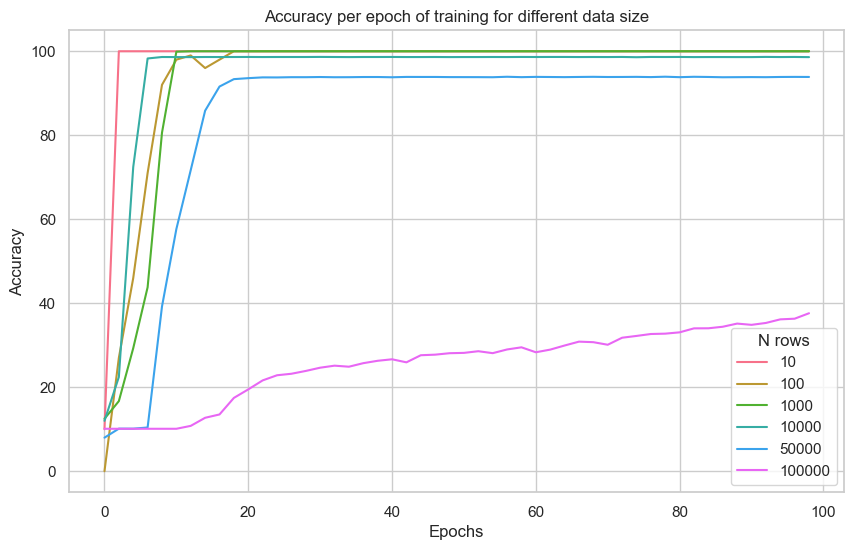

<IPython.core.display.Javascript object>

In [25]:
# results_melted = (
#     pd.DataFrame(results)
#     .reset_index()
#     .melt(id_vars="index", var_name="Series", value_name="Values")
#     .rename(columns={"index": "epochs"})
# )

# results_melted.epochs = results_melted.epochs * 2

# # Set the Seaborn style and color palette
# sns.set(style="whitegrid")
# palette = sns.color_palette("husl")  # 'husl' palette has beautiful colors

# # Plot the data using Seaborn
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_melted, x="epochs", y="Values", hue="Series", palette=palette)

# # Add labels and legend
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.title("Accuracy per epoch of training for different data size")
# plt.legend(title="N rows")

# # Show the plot
# plt.show()

In [11]:
# with open(
#     "../../../data/out_metrics/results_20241027_223358_init_trans.pkl", "rb"
# ) as file:
#     results = pickle.load(file)
# print(results[10000][-10:])
# print(results[50000][-10:])

[98.64, 98.61, 98.62, 98.62, 98.61, 98.61, 98.65, 98.62, 98.64, 98.6]
[93.828, 93.92, 93.876, 93.808, 93.828, 93.848, 93.826, 93.876, 93.894, 93.878]


<IPython.core.display.Javascript object>